In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm

In [3]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.1.0')

In [4]:
torch.cuda.set_device(0)

In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-urdu/language-model')

In [18]:
class UrduTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/urdu_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [19]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/urdu_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [20]:
urdu_vocab = Vocab(itos)

In [21]:
tokenizer = Tokenizer(tok_func=UrduTokenizer, lang='ur')

In [22]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [23]:
data_lm = TextLMDataBunch.from_folder(path=path/'transformer', tokenizer=tokenizer, vocab=urdu_vocab)

In [24]:
data_lm.save()

In [25]:
data_lm.show_batch()

idx,text
0,▁ xx bo s ▁ہر سٹ ، ▁الینوائے ▁ریاستہائے ▁متحدہ ▁امریکا ▁کا ▁ایک ▁شہر ▁جو ▁الینوائے ▁میں ▁واقع ▁ہے۔ ▁ہر سٹ ، ▁الینوائے ▁کی ▁مجموع ی ▁آبادی ▁80 5 ▁افراد ▁پر ▁مشتمل ▁ہے۔ ▁ xx bo s ▁مجلس ▁دستور ▁ساز ▁آئین ▁ہند ▁کی ▁تشکیل ▁کے ▁لیے ▁قائم ▁کی ▁گئی ▁تھی۔ برطانوی ▁سامراج ▁سے ▁بھارت ▁کی ▁آزادی ▁کے ▁بعد ▁مجلس ▁دستور ▁ساز ▁کے ▁ارکان ▁ہی ▁پہلی ▁پارلیمان ▁کے ▁ارکان ▁کے ▁طور
1,▁2 ▁اگست ▁1897 ء ▁تک ▁برطانوی ▁ہند ▁کے ▁صوبے ▁شمال ▁مشرقی ▁سرحدی ▁صوبے ▁کے ▁علاقے ▁مالاکنڈ ▁میں ▁برطانوی ▁افواج ▁کے ▁ایک ▁فوجی ▁کیمپ ▁کو ▁اس ▁وقت ▁مقامی ▁پشتون ▁جنگجوؤں ▁کی ▁جانب ▁سے ▁محاصرے ▁کا ▁سامنا ▁کرنا ▁پڑا ▁جب ▁ڈیورنڈ ▁لائن ▁کی ▁وجہ ▁سے ▁بہت ▁سے ▁پشتون وں ▁کی ▁زمین ▁دو ▁ملکوں ▁برطانوی ▁ہند ▁اور ▁افغانستان ▁کے ▁درمیان ▁منقسم ▁ہوکر ▁رہ ▁گئی۔ ▁اس ▁15 19 ▁میل ▁سرحدی ▁تقسیم ▁کو ▁افغان ▁انگریز
2,▁ہو ▁گئی ▁ہے ▁۔ ان ▁کے ▁علاوہ ▁مدارس ▁کے ▁طلبہ ▁کے ▁لیے ▁آسان ▁دینیات ▁ ، منصف ▁کے ▁مضامین ▁کا ▁مجموعہ ▁نقوش ▁م وع ظ ت ، ع صر ▁حاضر ▁کے ▁سماجی ▁مسائل ▁ ، دینی ▁و ▁عصری ▁تعلیم ▁: مس ائل ▁اور ▁حل ، ▁شمع ▁فرو ز اں ، ▁دعوت ی ▁و ▁تذکیر ی ▁انداز ▁کی ▁کتابیں ▁ہیں ▁ ۔آپ ▁کی ▁بقی ہ ▁کتابیں ▁حسب ▁ذیل ▁ہیں : راہ
3,"▁کی ▁مجموع ی ▁آبادی ▁13 ,108 ▁افراد ▁پر ▁مشتمل ▁ہے۔ ▁ xx bo s ▁ <unk> س راج ▁رئیس انی ▁کے ▁آخری ▁الفاظ ▁میر ▁سراج ▁خان ▁رئیس انی ▁ایک ▁پاکستانی ▁سیاست ▁دان ▁جن ▁کا ▁تعلق ▁بلوچستان ▁عوامی ▁پارٹی ▁سے ▁تھا۔ ▁وہ ▁13 ▁جولائی ▁2018 ء ▁کو ▁پاکستانی ▁عام ▁انتخابات ▁سے ▁قبل ▁اپنی ▁نشست ▁کے ▁لیے ▁مہم ▁چلا ▁رہے ▁تھے ▁اور ▁مہم ▁کے ▁دوران ▁خودکش ▁دھماکا ▁ہو ▁گیا ▁اور ▁فوت ▁ہو"
4,"▁خان <unk> ro z <unk> ▁نواب ▁خیر ▁بخش ▁مری ▁ <unk> ▁میر ▁بالا چ ▁مری ▁ <unk> ▁bra ham d agh <unk> g ti اللہ ▁نذر ▁بلوچ <unk> ja ved <unk> gal <unk> d <unk> ▁ <unk> عبد ال مالک ▁ریگ ی ▁ <unk> a b d ol ham id <unk> ▁r ig i ▁ <unk> ▁پاکستان ▁چین ▁بی ▁ایل ▁اے : ▁10,000 <unk> i ▁s ecurity ▁force s 1973"


In [26]:
len(data_lm.vocab.itos)

30000

In [27]:
learn = language_model_learner(data_lm, TransformerXL, pretrained=False)

In [28]:
gc.collect()

20

In [29]:
learn.model

SequentialRNN(
  (0): TransformerXL(
    (encoder): Embedding(30000, 410)
    (pos_enc): PositionalEncoding()
    (drop_emb): Dropout(p=0.1)
    (layers): ModuleList(
      (0): DecoderLayer(
        (mhra): MultiHeadRelativeAttention(
          (attention): Linear(in_features=410, out_features=1230, bias=False)
          (out): Linear(in_features=410, out_features=410, bias=False)
          (drop_att): Dropout(p=0.1)
          (drop_res): Dropout(p=0.1)
          (ln): LayerNorm(torch.Size([410]), eps=1e-05, elementwise_affine=True)
          (r_attn): Linear(in_features=410, out_features=410, bias=False)
        )
        (ff): SequentialEx(
          (layers): ModuleList(
            (0): Linear(in_features=410, out_features=2100, bias=True)
            (1): ReLU(inplace)
            (2): Dropout(p=0.1)
            (3): Linear(in_features=2100, out_features=410, bias=True)
            (4): Dropout(p=0.1)
            (5): MergeLayer()
            (6): LayerNorm(torch.Size([410]), eps

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


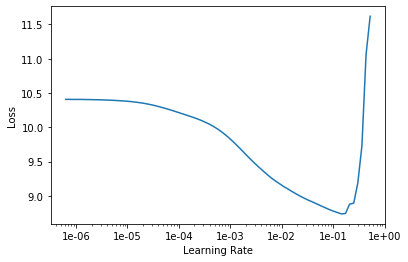

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(20, 1e-3, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='model')])

epoch,train_loss,valid_loss,accuracy,time
0,4.850728,4.848382,0.281403,32:48
1,4.303591,4.183890,0.341596,32:49
2,3.806851,3.737065,0.384724,32:49
3,3.692465,3.591967,0.393845,33:29
4,3.612472,3.553266,0.391731,34:56
5,3.610477,3.491082,0.396225,33:14
6,3.450806,3.401724,0.405535,32:54
7,3.453166,3.316013,0.413973,32:54
8,3.293946,3.237870,0.424381,32:54
9,3.179446,3.137322,0.437013,45:19


Better model found at epoch 0 with accuracy value: 0.2814030647277832.
Better model found at epoch 1 with accuracy value: 0.3415956497192383.
Better model found at epoch 2 with accuracy value: 0.38472414016723633.
Better model found at epoch 3 with accuracy value: 0.3938453495502472.
Better model found at epoch 5 with accuracy value: 0.3962252736091614.
Better model found at epoch 6 with accuracy value: 0.4055348336696625.
Better model found at epoch 7 with accuracy value: 0.4139733910560608.
Better model found at epoch 8 with accuracy value: 0.42438119649887085.
Better model found at epoch 9 with accuracy value: 0.4370129406452179.
Better model found at epoch 10 with accuracy value: 0.44824138283729553.
Better model found at epoch 11 with accuracy value: 0.4610903263092041.
Better model found at epoch 12 with accuracy value: 0.47489243745803833.
Better model found at epoch 13 with accuracy value: 0.4887722134590149.
Better model found at epoch 14 with accuracy value: 0.502534925937652

In [32]:
TEXT = "میں کروں گا"
N_WORDS = 40
N_SENTENCES = 2

In [33]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.9) for _ in range(N_SENTENCES)))

میں کروں گا ، ▁آم وں ▁گا ▁بھارت ▁کا ▁ایک ▁آباد ▁مقام ▁جو ▁نا ,332 - ▁نواح ▁میں ▁واقع ▁ہے۔ ▁میں ▁کر وں ▁گا ، ▁آم وں ▁گا ▁کی ▁مجموع ی ▁آبادی ▁20 ,267 ▁افراد ▁پر ▁مشتمل ▁ہے۔ ▁ xx bo s ▁
میں کروں گا ▁ریلوے ▁اسٹیشن ، ▁بھارت ▁میں ▁واقع ▁ہے۔ ▁سانچہ : بھارت ▁کے ▁ریلوے ▁اسٹیشن ▁ xx bo s ▁سینٹ - گرمین - دے - ٹاگ ے ▁متناسقات : ▁48 ▁g ▁سرخی وں ▁میں ▁ہوجائے ▁گا ▁اور ▁انکی ▁مدد ▁سے ▁کوئی ▁جنین


In [34]:
np.exp(2.53)

12.55350613666823

In [37]:
defaults.device = torch.device('cpu')
learn.model.eval()
learn.export()

In [38]:
# Generating embedding vectors for visualization

In [39]:
path

PosixPath('/home/gaurav/PycharmProjects/nlp-for-urdu/language-model')

In [40]:
# defaults.device = torch.device('cpu')

In [41]:
# learn = load_learner(path / 'UrduDataset/')

In [42]:
encoder = get_model(learn.model)[0]

In [43]:
encoder.state_dict()['encoder.weight'].shape

torch.Size([30000, 410])

In [44]:
embeddings = encoder.state_dict()['encoder.weight']

In [45]:
embeddings = np.array(embeddings)

In [46]:
embeddings[0].shape

(410,)

In [47]:
df = pd.DataFrame(embeddings)

In [48]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,400,401,402,403,404,405,406,407,408,409
0,0.274557,-0.066753,-0.156818,-0.158754,-0.255069,0.056576,0.053431,0.010714,-0.055425,0.088921,...,0.266454,-0.199348,0.143059,-0.254380,0.039857,-0.223381,-0.148715,0.528780,0.363054,0.355241
1,0.146572,-0.211287,0.088975,-0.141767,-0.108718,-0.089599,-0.023805,-0.106310,-0.146211,-0.033887,...,-0.106202,-0.031656,0.130010,-0.141824,-0.081605,-0.204387,-0.078683,0.149594,0.238998,0.068903
2,0.143155,-0.212103,0.087519,-0.136676,-0.105588,-0.087899,-0.021834,-0.109260,-0.135154,-0.034089,...,-0.108604,-0.031469,0.132030,-0.141408,-0.080047,-0.202075,-0.081220,0.143720,0.238397,0.061986
3,0.211712,0.308071,0.177578,0.125462,0.030023,-0.147874,0.096243,0.123668,-0.426578,-0.094092,...,0.229549,0.111376,0.169151,0.060326,-0.007837,0.019716,-0.110968,0.253889,-0.249155,-0.279694
4,-0.093593,0.164756,-0.161624,0.118464,-0.319576,0.171257,0.381318,-0.067512,-0.110809,0.196707,...,0.057503,0.078691,0.149484,-0.027757,-0.124158,-0.158895,-0.327782,-0.105953,-0.139209,-0.369162


In [49]:
df.shape

(30000, 410)

In [50]:
df.to_csv('embeddings_transformer.tsv', sep='\t', index=False, header=False)

In [51]:
df2 = pd.DataFrame(itos)

In [52]:
df2.head()

,0
0,<unk>
1,<s>
2,</s>
3,▁
4,▁کے


In [53]:
df2.shape

(30000, 1)

In [54]:
df2.to_csv('embeddings_transformer_metadata.tsv', sep='\t', index=False, header=False)

In [55]:
encoder.state_dict()['encoder.weight'][1]

tensor([ 0.1466, -0.2113,  0.0890, -0.1418, -0.1087, -0.0896, -0.0238, -0.1063,
        -0.1462, -0.0339, -0.1137,  0.0758,  0.0282,  0.0093,  0.0273,  0.1846,
         0.0425,  0.0837,  0.0428, -0.0909,  0.0373,  0.0754,  0.0702,  0.0277,
         0.0829, -0.0511, -0.0516, -0.1251, -0.0317,  0.2091,  0.0412, -0.1283,
         0.0293, -0.0450,  0.1177, -0.0839, -0.0771,  0.1631, -0.0322, -0.2058,
        -0.1828, -0.0136,  0.1263, -0.0554,  0.0994, -0.0014, -0.0203,  0.0995,
         0.0246, -0.0039,  0.0406, -0.0652, -0.1839, -0.1206, -0.1233,  0.0488,
         0.0199, -0.0707, -0.0410,  0.0083, -0.0793, -0.0641, -0.0422,  0.0103,
         0.1412, -0.0111,  0.0932, -0.1345, -0.0015, -0.0886,  0.1883,  0.1094,
         0.0177, -0.1486, -0.0350, -0.0388, -0.0448,  0.0604, -0.1848, -0.0791,
        -0.0317, -0.0367,  0.0415, -0.1847,  0.0167, -0.0286,  0.1326, -0.0165,
         0.0839, -0.1350,  0.0856, -0.1036,  0.0738,  0.0462, -0.1167, -0.0187,
        -0.0811,  0.1136,  0.1478,  0.14